In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

from sklearn.model_selection import train_test_split

import argparse

import models
import metrics
import utils
from train import *
from data import BUSIDataset

config = argparse.Namespace()

config.model = 'Wavelet_UNet_All'

config.SIZE = 256
config.batch_size = 8
config.num_workers = 2
config.n_channels = 1
config.lr = 0.0001
config.min_lr = 0.00001
config.epochs = 200
config.early_stopping = 50
config.patience = config.early_stopping
config.base_dir = ''
config.root_path = os.path.join(config.base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
config.semantic = False
config.device = torch.device('cuda:0')
config.classes = ['normal', 'benign', 'malignant']
config.labels = []
config.num_classes = 3 if config.semantic else 1
config.loss = 'BCEDiceLoss'
config.optimizer = 'Adam'
config.scheduler = 'CosineAnnealingLR'
config.weight_decay = 1e-4
config.momentum = 0.9
config.nesterov = False
config.seed = 42

if config.semantic:
    config.labels = config.classes
else:
    config.labels = ['cancer']

# write a function that sets the seed of all the libraries
def set_seed():
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    random.seed(config.seed)

In [2]:
if config.model is not None and not os.path.exists('models/%s' % config.model):
    os.makedirs('models/%s' % config.model)

print('-' * 20)
for key, value in config.__dict__.items():
    print('%s: %s' % (key, value))
print('-' * 20)


criterion = metrics.__dict__[config.loss]().cuda()
model = models.__dict__[config.model](n_channels=config.n_channels,
                                        n_classes=config.num_classes).cuda()


summary(model, (config.n_channels, config.SIZE, config.SIZE))

params = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([p.numel() for p in model.parameters()])

if config.optimizer == 'Adam':
    optimizer = optim.Adam(
        params, lr=config.lr, weight_decay=config.weight_decay)
elif config.optimizer == 'SGD':
    optimizer = optim.SGD(params, lr=config.lr, momentum=config.momentum,
                            nesterov=config.nesterov, weight_decay=config.weight_decay)
else:
    raise NotImplementedError

if config.scheduler == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config.epochs, eta_min=config.min_lr)
elif config.scheduler == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.factor, patience=config.patience,
                                                verbose=1, min_lr=config.min_lr)
else:
    scheduler = None

image_paths, mask_paths = utils.load_dataset(config.root_path)
print(f"Total Images: {len(image_paths)}, Masks: {len(mask_paths)}")

train_transform = Compose([
    RandomRotate90(),
    Flip(),
])

# image_paths, mask_paths = image_paths[:20], mask_paths[:20] # overfitting
X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths,  test_size=0.4, random_state=config.seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=config.seed)
# split X_test, y_test into validation and test, 50-50

train_dataset = BUSIDataset(image_paths=X_train, mask_paths=y_train, size=config.SIZE, transform=train_transform)
val_dataset = BUSIDataset(image_paths=X_val, mask_paths=y_val, size=config.SIZE, transform=None)
test_dataset = BUSIDataset(image_paths=X_test, mask_paths=y_test, size=config.SIZE, transform=None)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=False)

log = OrderedDict([
    ('train_lr', []),
    ('train_loss', []),
    ('train_iou', []),
    ('train_dice', []),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice', []),
])

best_dice = 0
trigger = 0
total_trained_epochs = 0
for epoch in range(config.epochs):
    print('Epoch [%d/%d]' % (epoch, config.epochs))
    total_trained_epochs += 1

    # train for one epoch
    train_log = train(train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(val_loader, model, criterion)

    if config.scheduler == 'CosineAnnealingLR':
        scheduler.step()
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler.step(val_log['loss'])

    print(f"loss {train_log['loss']:.4f} - iou {train_log['iou']:.4f} - dice {train_log['dice']:.4f} \
            - val_loss {val_log['loss']:.4f} - val_iou {val_log['iou']:.4f} - val_dice {val_log['dice']:.4f}") 

    print(train_log, val_log)
    log['train_lr'].append(config.lr)
    log['train_loss'].append(train_log['loss'])
    log['train_iou'].append(train_log['iou'])
    log['train_dice'].append(train_log['dice'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice'])

    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                                config.model, index=False)

    trigger += 1

    if val_log['dice'] > best_dice:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                    config.model)
        best_dice = val_log['dice']
        print("=> saved best model")
        trigger = 0

    # early stopping
    if config.early_stopping >= 0 and trigger >= config.early_stopping:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

print(f"Val Loss: {log['val_loss'][-1]:.4f} - Val IOU: {log['val_iou'][-1]:.4f} - Val Dice: {log['val_dice'][-1]:.4f}")

model.load_state_dict(torch.load('models/%s/model.pth' % config.model))
test_log = validate(test_loader, model, criterion)
print(f"Test loss {test_log['loss']:.4f} - Test IoU {test_log['iou']:.4f} - Test Dice {test_log['dice']:.4f}")
test_log_df = pd.DataFrame({'model': [config.model], 'epochs': [total_trained_epochs], 'size': [config.SIZE], 'params': [num_params], 'test_dice': [test_log['dice']], 'test_iou': [test_log['iou']], 'test_loss': [test_log['loss']]})
# append test_log_df to test_log.csv
test_log_df.to_csv('test_log.csv', mode='a', header=False, index=False)

--------------------
model: UNet
SIZE: 256
batch_size: 8
num_workers: 2
n_channels: 1
lr: 0.0001
min_lr: 1e-05
epochs: 200
early_stopping: 50
patience: 50
base_dir: 
root_path: breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/
semantic: False
device: cuda:0
classes: ['normal', 'benign', 'malignant']
labels: ['cancer']
num_classes: 1
loss: BCEDiceLoss
optimizer: Adam
scheduler: CosineAnnealingLR
weight_decay: 0.0001
momentum: 0.9
nesterov: False
seed: 42
--------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 256, 256]        --
|    └─Sequential: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        576
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-3                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,864
|    |    └─Bat

100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=1.12, iou=0.231, dice=0.37] 


loss 1.0535 - iou 0.2324 - dice 0.3656             - val_loss 1.1213 - val_iou 0.2312 - val_dice 0.3695
OrderedDict({'loss': 1.0535270491826165, 'iou': 0.23237446900019373, 'dice': 0.3655583546988736}) OrderedDict({'loss': 1.121333586153134, 'iou': 0.23119613563049365, 'dice': 0.3695269772941559})
=> saved best model
Epoch [1/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.963, iou=0.301, dice=0.455]


loss 0.9292 - iou 0.3262 - dice 0.4847             - val_loss 0.9629 - val_iou 0.3006 - val_dice 0.4553
OrderedDict({'loss': 0.9291661983912753, 'iou': 0.3262317496255101, 'dice': 0.4847497845267977}) OrderedDict({'loss': 0.9629468090774477, 'iou': 0.30061759675673777, 'dice': 0.4552692385509873})
=> saved best model
Epoch [2/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.875, iou=0.361, dice=0.525]


loss 0.8766 - iou 0.3605 - dice 0.5224             - val_loss 0.8752 - val_iou 0.3606 - val_dice 0.5250
OrderedDict({'loss': 0.876608445472324, 'iou': 0.3605074872596638, 'dice': 0.5223944695226086}) OrderedDict({'loss': 0.8751687938852828, 'iou': 0.36059906989214335, 'dice': 0.5250062241858805})
=> saved best model
Epoch [3/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=1.21, iou=0.172, dice=0.289]


loss 0.8454 - iou 0.3874 - dice 0.5512             - val_loss 1.2063 - val_iou 0.1721 - val_dice 0.2885
OrderedDict({'loss': 0.8454482112963175, 'iou': 0.38740844629716953, 'dice': 0.5511609056319835}) OrderedDict({'loss': 1.2063110540079516, 'iou': 0.17205980233162904, 'dice': 0.28851051027445107})
Epoch [4/200]


100%|██████████| 17/17 [00:04<00:00,  3.73it/s, loss=0.82, iou=0.442, dice=0.601] 


loss 0.8336 - iou 0.3840 - dice 0.5455             - val_loss 0.8204 - val_iou 0.4423 - val_dice 0.6013
OrderedDict({'loss': 0.8335722647991377, 'iou': 0.38402960139642145, 'dice': 0.5455326627542619}) OrderedDict({'loss': 0.8203703165054321, 'iou': 0.4423026286663555, 'dice': 0.6013490953808048})
=> saved best model
Epoch [5/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.779, iou=0.454, dice=0.615]


loss 0.8051 - iou 0.3986 - dice 0.5622             - val_loss 0.7794 - val_iou 0.4536 - val_dice 0.6150
OrderedDict({'loss': 0.8051421992557565, 'iou': 0.3985847240035984, 'dice': 0.5621593745176521}) OrderedDict({'loss': 0.7793856138406798, 'iou': 0.45355569787113253, 'dice': 0.6149518450030845})
=> saved best model
Epoch [6/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.782, iou=0.418, dice=0.58] 


loss 0.7736 - iou 0.4301 - dice 0.5945             - val_loss 0.7817 - val_iou 0.4183 - val_dice 0.5801
OrderedDict({'loss': 0.773621936434323, 'iou': 0.430145854315293, 'dice': 0.5945447114508721}) OrderedDict({'loss': 0.7817185359407764, 'iou': 0.41830647047311315, 'dice': 0.5800735672445857})
Epoch [7/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.758, iou=0.442, dice=0.597]


loss 0.7543 - iou 0.4491 - dice 0.6122             - val_loss 0.7580 - val_iou 0.4424 - val_dice 0.5972
OrderedDict({'loss': 0.7543266071486718, 'iou': 0.4490714242063435, 'dice': 0.6121529097483199}) OrderedDict({'loss': 0.7579601203748422, 'iou': 0.4424091362134868, 'dice': 0.5971872162949873})
Epoch [8/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.751, iou=0.47, dice=0.631] 


loss 0.7433 - iou 0.4466 - dice 0.6072             - val_loss 0.7513 - val_iou 0.4704 - val_dice 0.6307
OrderedDict({'loss': 0.7433278259542799, 'iou': 0.4466197021752386, 'dice': 0.6071865160837855}) OrderedDict({'loss': 0.7512776361879452, 'iou': 0.47040211146173116, 'dice': 0.6307082050603022})
=> saved best model
Epoch [9/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.728, iou=0.471, dice=0.627]


loss 0.7162 - iou 0.4630 - dice 0.6223             - val_loss 0.7283 - val_iou 0.4709 - val_dice 0.6273
OrderedDict({'loss': 0.7161871348459696, 'iou': 0.46303149357842927, 'dice': 0.6223487601875657}) OrderedDict({'loss': 0.7283266514770744, 'iou': 0.47092584464759535, 'dice': 0.627264686163743})
=> saved best model
Epoch [10/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.708, iou=0.455, dice=0.615]


loss 0.7273 - iou 0.4265 - dice 0.5877             - val_loss 0.7077 - val_iou 0.4546 - val_dice 0.6155
OrderedDict({'loss': 0.7272542604466075, 'iou': 0.4264847597730844, 'dice': 0.5876909459527805}) OrderedDict({'loss': 0.7076634062353031, 'iou': 0.45458968166862035, 'dice': 0.6154630898593767})
Epoch [11/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.773, iou=0.363, dice=0.53] 


loss 0.6908 - iou 0.4770 - dice 0.6373             - val_loss 0.7725 - val_iou 0.3633 - val_dice 0.5303
OrderedDict({'loss': 0.6907831455014416, 'iou': 0.47696588849998234, 'dice': 0.6373297563182744}) OrderedDict({'loss': 0.772510942562606, 'iou': 0.36329792080668627, 'dice': 0.5302944482912676})
Epoch [12/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.664, iou=0.485, dice=0.643]


loss 0.6734 - iou 0.4743 - dice 0.6330             - val_loss 0.6635 - val_iou 0.4852 - val_dice 0.6427
OrderedDict({'loss': 0.6733956201789305, 'iou': 0.474293438463509, 'dice': 0.6330363082880126}) OrderedDict({'loss': 0.6635285033736118, 'iou': 0.4851721790100063, 'dice': 0.642689704078576})
=> saved best model
Epoch [13/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.685, iou=0.52, dice=0.669] 


loss 0.6562 - iou 0.4858 - dice 0.6455             - val_loss 0.6852 - val_iou 0.5197 - val_dice 0.6692
OrderedDict({'loss': 0.6562174749128598, 'iou': 0.48576861963039786, 'dice': 0.6455196754910527}) OrderedDict({'loss': 0.6851973709209945, 'iou': 0.5197318043558411, 'dice': 0.6692129781364664})
=> saved best model
Epoch [14/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.66, iou=0.519, dice=0.671] 


loss 0.6353 - iou 0.5035 - dice 0.6602             - val_loss 0.6598 - val_iou 0.5194 - val_dice 0.6708
OrderedDict({'loss': 0.6352793767894667, 'iou': 0.5034529505462929, 'dice': 0.6601525850926192}) OrderedDict({'loss': 0.6597727814386057, 'iou': 0.5193804422428858, 'dice': 0.6708308378316674})
Epoch [15/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.64, iou=0.496, dice=0.649] 


loss 0.6266 - iou 0.5110 - dice 0.6686             - val_loss 0.6404 - val_iou 0.4956 - val_dice 0.6490
OrderedDict({'loss': 0.626577806226986, 'iou': 0.5110485164386358, 'dice': 0.6686422060601301}) OrderedDict({'loss': 0.640395058910976, 'iou': 0.4956390785679403, 'dice': 0.6490091461258304})
Epoch [16/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.597, iou=0.531, dice=0.687]


loss 0.6101 - iou 0.5129 - dice 0.6709             - val_loss 0.5970 - val_iou 0.5306 - val_dice 0.6873
OrderedDict({'loss': 0.6100745520640894, 'iou': 0.5128593332887941, 'dice': 0.6708509545229301}) OrderedDict({'loss': 0.5970047421233599, 'iou': 0.5306164626723945, 'dice': 0.6872904604552417})
=> saved best model
Epoch [17/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.706, iou=0.394, dice=0.556]


loss 0.5975 - iou 0.5179 - dice 0.6769             - val_loss 0.7063 - val_iou 0.3944 - val_dice 0.5560
OrderedDict({'loss': 0.5974711345643112, 'iou': 0.517927879502174, 'dice': 0.6769147888637375}) OrderedDict({'loss': 0.7062570429587549, 'iou': 0.39444036645907943, 'dice': 0.555984808662902})
Epoch [18/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.636, iou=0.474, dice=0.631]


loss 0.5834 - iou 0.5303 - dice 0.6868             - val_loss 0.6362 - val_iou 0.4735 - val_dice 0.6309
OrderedDict({'loss': 0.5833699795388684, 'iou': 0.5303488032013688, 'dice': 0.6868176173309365}) OrderedDict({'loss': 0.6362142244050669, 'iou': 0.47353096950552837, 'dice': 0.6309316987207049})
Epoch [19/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.573, iou=0.53, dice=0.68]  


loss 0.5767 - iou 0.5231 - dice 0.6783             - val_loss 0.5732 - val_iou 0.5295 - val_dice 0.6804
OrderedDict({'loss': 0.5767253465259198, 'iou': 0.5230543998986257, 'dice': 0.678335756651108}) OrderedDict({'loss': 0.573162859262422, 'iou': 0.5295386919686101, 'dice': 0.6803894705945787})
Epoch [20/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.596, iou=0.484, dice=0.641]


loss 0.5599 - iou 0.5246 - dice 0.6832             - val_loss 0.5959 - val_iou 0.4840 - val_dice 0.6412
OrderedDict({'loss': 0.5599390581711051, 'iou': 0.5245892431597288, 'dice': 0.6831504684321118}) OrderedDict({'loss': 0.5958641785983891, 'iou': 0.4840083070759307, 'dice': 0.6412058911556356})
Epoch [21/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.584, iou=0.498, dice=0.649]


loss 0.5485 - iou 0.5406 - dice 0.6958             - val_loss 0.5843 - val_iou 0.4981 - val_dice 0.6492
OrderedDict({'loss': 0.5485348695332242, 'iou': 0.5406120631663334, 'dice': 0.6957598872392883}) OrderedDict({'loss': 0.5843389570250992, 'iou': 0.498110651101166, 'dice': 0.6491730289519962})
Epoch [22/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.638, iou=0.445, dice=0.61] 


loss 0.5232 - iou 0.5587 - dice 0.7092             - val_loss 0.6379 - val_iou 0.4449 - val_dice 0.6096
OrderedDict({'loss': 0.5232031351512241, 'iou': 0.558656106715656, 'dice': 0.7092355487056549}) OrderedDict({'loss': 0.6378981337066769, 'iou': 0.4448737370158952, 'dice': 0.6095853946975898})
Epoch [23/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.518, iou=0.541, dice=0.685]


loss 0.5420 - iou 0.5262 - dice 0.6799             - val_loss 0.5185 - val_iou 0.5414 - val_dice 0.6850
OrderedDict({'loss': 0.5420255697879595, 'iou': 0.5261805789089327, 'dice': 0.6798551338709136}) OrderedDict({'loss': 0.5184626006340796, 'iou': 0.5413748421743885, 'dice': 0.684952956130026})
=> saved best model
Epoch [24/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.518, iou=0.546, dice=0.696]


loss 0.5200 - iou 0.5425 - dice 0.6941             - val_loss 0.5176 - val_iou 0.5456 - val_dice 0.6961
OrderedDict({'loss': 0.5199703571108198, 'iou': 0.5425347165146914, 'dice': 0.6940544110758087}) OrderedDict({'loss': 0.5175883756127468, 'iou': 0.5455606096904235, 'dice': 0.6960995614188875})
=> saved best model
Epoch [25/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.532, iou=0.486, dice=0.65] 


loss 0.5250 - iou 0.5239 - dice 0.6811             - val_loss 0.5318 - val_iou 0.4863 - val_dice 0.6500
OrderedDict({'loss': 0.5250488316889891, 'iou': 0.5238989909999566, 'dice': 0.681146005531395}) OrderedDict({'loss': 0.5318205245705538, 'iou': 0.48629783810938654, 'dice': 0.6500131490673642})
Epoch [26/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.488, iou=0.553, dice=0.696]


loss 0.5099 - iou 0.5417 - dice 0.6935             - val_loss 0.4885 - val_iou 0.5535 - val_dice 0.6964
OrderedDict({'loss': 0.5098680365331394, 'iou': 0.5417369923277339, 'dice': 0.6934959840487142}) OrderedDict({'loss': 0.48848235422326614, 'iou': 0.553464899304911, 'dice': 0.6963986139449166})
=> saved best model
Epoch [27/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.495, iou=0.547, dice=0.701]


loss 0.4969 - iou 0.5487 - dice 0.7013             - val_loss 0.4948 - val_iou 0.5473 - val_dice 0.7012
OrderedDict({'loss': 0.4969290670045872, 'iou': 0.5486822038417069, 'dice': 0.7013141387114384}) OrderedDict({'loss': 0.49484431235365167, 'iou': 0.5472687476923711, 'dice': 0.7012393784441755})
Epoch [28/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.568, iou=0.489, dice=0.645]


loss 0.4800 - iou 0.5644 - dice 0.7157             - val_loss 0.5684 - val_iou 0.4888 - val_dice 0.6451
OrderedDict({'loss': 0.4799742286967248, 'iou': 0.5643635817861591, 'dice': 0.7157253926450446}) OrderedDict({'loss': 0.5684175255686738, 'iou': 0.4888323549335972, 'dice': 0.6450871096554615})
Epoch [29/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.483, iou=0.573, dice=0.722]


loss 0.4807 - iou 0.5599 - dice 0.7083             - val_loss 0.4834 - val_iou 0.5732 - val_dice 0.7224
OrderedDict({'loss': 0.4807189979504064, 'iou': 0.5598853523929331, 'dice': 0.7082550833970982}) OrderedDict({'loss': 0.483359763326571, 'iou': 0.5731799707815186, 'dice': 0.7223633772174645})
=> saved best model
Epoch [30/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.499, iou=0.529, dice=0.686]


loss 0.4899 - iou 0.5376 - dice 0.6891             - val_loss 0.4991 - val_iou 0.5290 - val_dice 0.6862
OrderedDict({'loss': 0.48987715238148405, 'iou': 0.5376286332056173, 'dice': 0.6890802364087086}) OrderedDict({'loss': 0.4990894953871882, 'iou': 0.5290278422265606, 'dice': 0.6861952444416367})
Epoch [31/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.454, iou=0.569, dice=0.713]


loss 0.4746 - iou 0.5597 - dice 0.7103             - val_loss 0.4542 - val_iou 0.5688 - val_dice 0.7132
OrderedDict({'loss': 0.47460871566202223, 'iou': 0.5596749501031156, 'dice': 0.7102557135324876}) OrderedDict({'loss': 0.4541768909886826, 'iou': 0.5688353590844792, 'dice': 0.7131620287147591})
Epoch [32/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.464, iou=0.566, dice=0.71] 


loss 0.4662 - iou 0.5571 - dice 0.7085             - val_loss 0.4643 - val_iou 0.5656 - val_dice 0.7102
OrderedDict({'loss': 0.4661737741883268, 'iou': 0.5570630239081675, 'dice': 0.7084702282173754}) OrderedDict({'loss': 0.4642916750307231, 'iou': 0.5656140445579692, 'dice': 0.7101703170881382})
Epoch [33/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.479, iou=0.572, dice=0.715]


loss 0.4690 - iou 0.5533 - dice 0.7037             - val_loss 0.4788 - val_iou 0.5721 - val_dice 0.7150
OrderedDict({'loss': 0.4690168622842769, 'iou': 0.5533042518380763, 'dice': 0.7037362406698683}) OrderedDict({'loss': 0.47876715567684913, 'iou': 0.5721246145562194, 'dice': 0.7150218978955533})
Epoch [34/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.561, iou=0.504, dice=0.658]


loss 0.4426 - iou 0.5904 - dice 0.7373             - val_loss 0.5609 - val_iou 0.5036 - val_dice 0.6575
OrderedDict({'loss': 0.4425641129311827, 'iou': 0.5903960471326867, 'dice': 0.7373248487679881}) OrderedDict({'loss': 0.5608956434930018, 'iou': 0.5035511802208488, 'dice': 0.6575342844056109})
Epoch [35/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.477, iou=0.556, dice=0.702]


loss 0.4685 - iou 0.5665 - dice 0.7155             - val_loss 0.4766 - val_iou 0.5562 - val_dice 0.7023
OrderedDict({'loss': 0.4685488106663694, 'iou': 0.5664890742542608, 'dice': 0.7154654166021251}) OrderedDict({'loss': 0.4765983531179354, 'iou': 0.5561604810173901, 'dice': 0.7023329909396862})
Epoch [36/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.47, iou=0.516, dice=0.665] 


loss 0.4748 - iou 0.5385 - dice 0.6945             - val_loss 0.4700 - val_iou 0.5158 - val_dice 0.6653
OrderedDict({'loss': 0.4748481330797844, 'iou': 0.5385457675492821, 'dice': 0.6945170804039492}) OrderedDict({'loss': 0.470042814580045, 'iou': 0.5158193669191689, 'dice': 0.6653040047901597})
Epoch [37/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.454, iou=0.569, dice=0.707]


loss 0.4270 - iou 0.5871 - dice 0.7340             - val_loss 0.4541 - val_iou 0.5692 - val_dice 0.7066
OrderedDict({'loss': 0.42698286151148607, 'iou': 0.5870888796339364, 'dice': 0.7340019434170992}) OrderedDict({'loss': 0.45413472670917365, 'iou': 0.5692132686092878, 'dice': 0.7065791218693156})
Epoch [38/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.467, iou=0.548, dice=0.689]


loss 0.4271 - iou 0.5875 - dice 0.7351             - val_loss 0.4667 - val_iou 0.5483 - val_dice 0.6889
OrderedDict({'loss': 0.4270951555869014, 'iou': 0.5875428757430639, 'dice': 0.7350545119733405}) OrderedDict({'loss': 0.4667188384851744, 'iou': 0.5482720885725012, 'dice': 0.6889207888009148})
Epoch [39/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.43, iou=0.574, dice=0.72]  


loss 0.4368 - iou 0.5695 - dice 0.7196             - val_loss 0.4302 - val_iou 0.5744 - val_dice 0.7196
OrderedDict({'loss': 0.43684541595350834, 'iou': 0.569472560371804, 'dice': 0.7195987303774188}) OrderedDict({'loss': 0.43017504728117656, 'iou': 0.5743655262462263, 'dice': 0.7196065838066295})
=> saved best model
Epoch [40/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.443, iou=0.551, dice=0.695]


loss 0.4220 - iou 0.5901 - dice 0.7360             - val_loss 0.4429 - val_iou 0.5514 - val_dice 0.6953
OrderedDict({'loss': 0.4220405715642516, 'iou': 0.5900902124599168, 'dice': 0.7360469511163226}) OrderedDict({'loss': 0.4428743567577628, 'iou': 0.5513613513625979, 'dice': 0.6952876903059191})
Epoch [41/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.538, iou=0.497, dice=0.654]


loss 0.4431 - iou 0.5611 - dice 0.7138             - val_loss 0.5383 - val_iou 0.4968 - val_dice 0.6542
OrderedDict({'loss': 0.44312947251133084, 'iou': 0.5611434485890481, 'dice': 0.7137622401989483}) OrderedDict({'loss': 0.5382733719293461, 'iou': 0.49677783879944926, 'dice': 0.6541874593607743})
Epoch [42/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.469, iou=0.561, dice=0.708]


loss 0.4128 - iou 0.5957 - dice 0.7404             - val_loss 0.4694 - val_iou 0.5608 - val_dice 0.7082
OrderedDict({'loss': 0.4127785532744889, 'iou': 0.5957007195796131, 'dice': 0.7404012827212219}) OrderedDict({'loss': 0.4693910368653231, 'iou': 0.5607719321924414, 'dice': 0.7082279002976736})
Epoch [43/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.53, iou=0.49, dice=0.651]  


loss 0.4184 - iou 0.5866 - dice 0.7313             - val_loss 0.5303 - val_iou 0.4903 - val_dice 0.6508
OrderedDict({'loss': 0.41843625810957447, 'iou': 0.586621868069373, 'dice': 0.7313295948382729}) OrderedDict({'loss': 0.5302907752898313, 'iou': 0.49026415840736726, 'dice': 0.6508184932608391})
Epoch [44/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.431, iou=0.563, dice=0.713]


loss 0.4001 - iou 0.5976 - dice 0.7411             - val_loss 0.4311 - val_iou 0.5633 - val_dice 0.7126
OrderedDict({'loss': 0.4001105132791185, 'iou': 0.5975788590984685, 'dice': 0.7411182779238518}) OrderedDict({'loss': 0.4311465507791948, 'iou': 0.5633173925118998, 'dice': 0.7126464379573809})
Epoch [45/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.427, iou=0.585, dice=0.727]


loss 0.4160 - iou 0.5856 - dice 0.7339             - val_loss 0.4269 - val_iou 0.5854 - val_dice 0.7266
OrderedDict({'loss': 0.41598839981039776, 'iou': 0.5856185980256591, 'dice': 0.7339230082925942}) OrderedDict({'loss': 0.42693546114041825, 'iou': 0.5854232660512974, 'dice': 0.726644449316841})
=> saved best model
Epoch [46/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.417, iou=0.573, dice=0.72] 


loss 0.3991 - iou 0.5944 - dice 0.7392             - val_loss 0.4174 - val_iou 0.5727 - val_dice 0.7196
OrderedDict({'loss': 0.39911658278445605, 'iou': 0.5943773852162823, 'dice': 0.7392241652823374}) OrderedDict({'loss': 0.4173921901126241, 'iou': 0.5727415984143972, 'dice': 0.7195694914220221})
Epoch [47/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.455, iou=0.536, dice=0.69] 


loss 0.3946 - iou 0.5980 - dice 0.7403             - val_loss 0.4546 - val_iou 0.5361 - val_dice 0.6898
OrderedDict({'loss': 0.39463113325158344, 'iou': 0.5979612849525969, 'dice': 0.7402731923702609}) OrderedDict({'loss': 0.4545931099921234, 'iou': 0.5361092808129116, 'dice': 0.6898449477353974})
Epoch [48/200]


100%|██████████| 17/17 [00:04<00:00,  3.76it/s, loss=0.429, iou=0.567, dice=0.713]


loss 0.4048 - iou 0.5809 - dice 0.7289             - val_loss 0.4286 - val_iou 0.5668 - val_dice 0.7127
OrderedDict({'loss': 0.4047878943767744, 'iou': 0.5809016180479033, 'dice': 0.7288745937917215}) OrderedDict({'loss': 0.42855657625568006, 'iou': 0.5667859487173679, 'dice': 0.712722839976282})
Epoch [49/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.419, iou=0.572, dice=0.713]


loss 0.3939 - iou 0.6031 - dice 0.7459             - val_loss 0.4187 - val_iou 0.5715 - val_dice 0.7125
OrderedDict({'loss': 0.39390313225923124, 'iou': 0.603112062461904, 'dice': 0.7458980836656925}) OrderedDict({'loss': 0.41870721273644024, 'iou': 0.571547880852086, 'dice': 0.7125176954254135})
Epoch [50/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.403, iou=0.582, dice=0.717]


loss 0.3751 - iou 0.6134 - dice 0.7562             - val_loss 0.4027 - val_iou 0.5821 - val_dice 0.7167
OrderedDict({'loss': 0.3750914977383368, 'iou': 0.6133898858510738, 'dice': 0.756156297117857}) OrderedDict({'loss': 0.40265127854753835, 'iou': 0.5820668292352317, 'dice': 0.7166937748417178})
Epoch [51/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.5, iou=0.518, dice=0.669]  


loss 0.3932 - iou 0.6035 - dice 0.7471             - val_loss 0.4997 - val_iou 0.5181 - val_dice 0.6690
OrderedDict({'loss': 0.3931950896056657, 'iou': 0.6034815686039391, 'dice': 0.7471399533838774}) OrderedDict({'loss': 0.4997187778931256, 'iou': 0.5181042711765655, 'dice': 0.6689731405407054})
Epoch [52/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.411, iou=0.567, dice=0.709]


loss 0.3882 - iou 0.6080 - dice 0.7493             - val_loss 0.4107 - val_iou 0.5671 - val_dice 0.7089
OrderedDict({'loss': 0.3881574561915447, 'iou': 0.6079629608308942, 'dice': 0.7493162920321522}) OrderedDict({'loss': 0.41074112034583277, 'iou': 0.567075157902878, 'dice': 0.7089357964040244})
Epoch [53/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.414, iou=0.578, dice=0.721]


loss 0.3805 - iou 0.6075 - dice 0.7489             - val_loss 0.4145 - val_iou 0.5777 - val_dice 0.7213
OrderedDict({'loss': 0.38052630701015905, 'iou': 0.6075266271760259, 'dice': 0.7489475021886525}) OrderedDict({'loss': 0.4144757563291594, 'iou': 0.577706398625366, 'dice': 0.7212813031640591})
Epoch [54/200]


100%|██████████| 17/17 [00:04<00:00,  3.90it/s, loss=0.488, iou=0.517, dice=0.67] 


loss 0.3927 - iou 0.5980 - dice 0.7431             - val_loss 0.4880 - val_iou 0.5166 - val_dice 0.6698
OrderedDict({'loss': 0.3926909034399642, 'iou': 0.5979719100358052, 'dice': 0.7431427113472503}) OrderedDict({'loss': 0.4879619474558867, 'iou': 0.5165780604210027, 'dice': 0.6697974783384477})
Epoch [55/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.401, iou=0.588, dice=0.724]


loss 0.3833 - iou 0.6081 - dice 0.7506             - val_loss 0.4010 - val_iou 0.5877 - val_dice 0.7244
OrderedDict({'loss': 0.38327392751408607, 'iou': 0.6080715655562753, 'dice': 0.7506319698341646}) OrderedDict({'loss': 0.40102439275545665, 'iou': 0.5876893921812836, 'dice': 0.7244418224176743})
=> saved best model
Epoch [56/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.394, iou=0.609, dice=0.746]


loss 0.3540 - iou 0.6360 - dice 0.7730             - val_loss 0.3942 - val_iou 0.6094 - val_dice 0.7461
OrderedDict({'loss': 0.3539584460332222, 'iou': 0.6360161175798115, 'dice': 0.7729857680296661}) OrderedDict({'loss': 0.39416535857111906, 'iou': 0.609362257478508, 'dice': 0.7460532191846716})
=> saved best model
Epoch [57/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.433, iou=0.551, dice=0.701]


loss 0.3678 - iou 0.6142 - dice 0.7556             - val_loss 0.4334 - val_iou 0.5506 - val_dice 0.7006
OrderedDict({'loss': 0.36779676208791046, 'iou': 0.6142160367111822, 'dice': 0.7556287961953229}) OrderedDict({'loss': 0.4334077100421107, 'iou': 0.5506214563322529, 'dice': 0.7005871491406083})
Epoch [58/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.415, iou=0.576, dice=0.718]


loss 0.3638 - iou 0.6286 - dice 0.7658             - val_loss 0.4146 - val_iou 0.5761 - val_dice 0.7184
OrderedDict({'loss': 0.36382892789299953, 'iou': 0.6286024556113519, 'dice': 0.7658057615979844}) OrderedDict({'loss': 0.41459569635317306, 'iou': 0.5761089216460621, 'dice': 0.7184150470229258})
Epoch [59/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.426, iou=0.572, dice=0.705]


loss 0.3573 - iou 0.6237 - dice 0.7613             - val_loss 0.4264 - val_iou 0.5720 - val_dice 0.7047
OrderedDict({'loss': 0.3573472309358341, 'iou': 0.623657415751796, 'dice': 0.7612755233022735}) OrderedDict({'loss': 0.4264317931130875, 'iou': 0.571959155879344, 'dice': 0.7046818561931711})
Epoch [60/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.414, iou=0.556, dice=0.702]


loss 0.3514 - iou 0.6214 - dice 0.7612             - val_loss 0.4140 - val_iou 0.5563 - val_dice 0.7025
OrderedDict({'loss': 0.35139303907905656, 'iou': 0.6213579052174806, 'dice': 0.7611665475458268}) OrderedDict({'loss': 0.4139868573740471, 'iou': 0.5563070632034925, 'dice': 0.7024735431407297})
Epoch [61/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.417, iou=0.552, dice=0.697]


loss 0.3534 - iou 0.6340 - dice 0.7708             - val_loss 0.4171 - val_iou 0.5521 - val_dice 0.6970
OrderedDict({'loss': 0.3533500104220872, 'iou': 0.6339745865082318, 'dice': 0.7707551097702704}) OrderedDict({'loss': 0.41709121905787044, 'iou': 0.5521456635263264, 'dice': 0.6969573786221874})
Epoch [62/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.419, iou=0.562, dice=0.709]


loss 0.3468 - iou 0.6370 - dice 0.7736             - val_loss 0.4193 - val_iou 0.5621 - val_dice 0.7092
OrderedDict({'loss': 0.34680516725962923, 'iou': 0.6370140629220806, 'dice': 0.7736084729753389}) OrderedDict({'loss': 0.4193062234756558, 'iou': 0.5621040077945035, 'dice': 0.7091784896761805})
Epoch [63/200]


100%|██████████| 17/17 [00:04<00:00,  3.70it/s, loss=0.424, iou=0.558, dice=0.709]


loss 0.3637 - iou 0.6142 - dice 0.7534             - val_loss 0.4239 - val_iou 0.5576 - val_dice 0.7085
OrderedDict({'loss': 0.36373158889947477, 'iou': 0.6142358529943559, 'dice': 0.7533602171067579}) OrderedDict({'loss': 0.423941210951916, 'iou': 0.5576163822471281, 'dice': 0.708538287253185})
Epoch [64/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.407, iou=0.58, dice=0.723] 


loss 0.3465 - iou 0.6304 - dice 0.7679             - val_loss 0.4066 - val_iou 0.5797 - val_dice 0.7232
OrderedDict({'loss': 0.3464523888740343, 'iou': 0.6304282496429989, 'dice': 0.7679176454104378}) OrderedDict({'loss': 0.40658280669256697, 'iou': 0.5797095953372099, 'dice': 0.7231843368837755})
Epoch [65/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.426, iou=0.584, dice=0.726]


loss 0.3645 - iou 0.6174 - dice 0.7566             - val_loss 0.4255 - val_iou 0.5840 - val_dice 0.7259
OrderedDict({'loss': 0.36449102335369465, 'iou': 0.6174345896091625, 'dice': 0.756552626289869}) OrderedDict({'loss': 0.4255059038021768, 'iou': 0.5839949574313064, 'dice': 0.7259408067708059})
Epoch [66/200]


100%|██████████| 17/17 [00:04<00:00,  3.70it/s, loss=0.392, iou=0.584, dice=0.721]


loss 0.3338 - iou 0.6362 - dice 0.7724             - val_loss 0.3923 - val_iou 0.5843 - val_dice 0.7209
OrderedDict({'loss': 0.33379911792646977, 'iou': 0.6361762727453878, 'dice': 0.7724018341284686}) OrderedDict({'loss': 0.3922669762788817, 'iou': 0.584324468857131, 'dice': 0.7208976214359504})
Epoch [67/200]


100%|██████████| 17/17 [00:04<00:00,  3.69it/s, loss=0.484, iou=0.511, dice=0.665]


loss 0.3384 - iou 0.6359 - dice 0.7743             - val_loss 0.4840 - val_iou 0.5110 - val_dice 0.6650
OrderedDict({'loss': 0.3384171174359076, 'iou': 0.6359070356557799, 'dice': 0.7742590256292747}) OrderedDict({'loss': 0.48396382105442903, 'iou': 0.5109698329202285, 'dice': 0.6650148970453623})
Epoch [68/200]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s, loss=0.477, iou=0.52, dice=0.67]  


loss 0.3261 - iou 0.6517 - dice 0.7841             - val_loss 0.4766 - val_iou 0.5199 - val_dice 0.6703
OrderedDict({'loss': 0.3260930226635687, 'iou': 0.6516725081342892, 'dice': 0.7841300640312955}) OrderedDict({'loss': 0.4765760949415754, 'iou': 0.5198669774277183, 'dice': 0.6702713460785938})
Epoch [69/200]


100%|██████████| 17/17 [00:04<00:00,  3.66it/s, loss=0.403, iou=0.582, dice=0.722]


loss 0.3577 - iou 0.6343 - dice 0.7700             - val_loss 0.4032 - val_iou 0.5820 - val_dice 0.7217
OrderedDict({'loss': 0.35767367328565147, 'iou': 0.634284014114807, 'dice': 0.7700017164325476}) OrderedDict({'loss': 0.4031559465698494, 'iou': 0.5820103175093773, 'dice': 0.7217387118176525})
Epoch [70/200]


100%|██████████| 17/17 [00:04<00:00,  3.65it/s, loss=0.398, iou=0.555, dice=0.696]


loss 0.3496 - iou 0.6312 - dice 0.7644             - val_loss 0.3983 - val_iou 0.5551 - val_dice 0.6959
OrderedDict({'loss': 0.3496066098360671, 'iou': 0.6311895351563863, 'dice': 0.7643765015748828}) OrderedDict({'loss': 0.39826331905616347, 'iou': 0.5550937498341619, 'dice': 0.6959416157210099})
Epoch [71/200]


100%|██████████| 17/17 [00:04<00:00,  3.72it/s, loss=0.395, iou=0.581, dice=0.728]


loss 0.3108 - iou 0.6623 - dice 0.7913             - val_loss 0.3947 - val_iou 0.5810 - val_dice 0.7275
OrderedDict({'loss': 0.3107553579143642, 'iou': 0.6622717299645943, 'dice': 0.7913050369244056}) OrderedDict({'loss': 0.3946996652340704, 'iou': 0.5810246584564621, 'dice': 0.7275262346956325})
Epoch [72/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.397, iou=0.574, dice=0.719]


loss 0.3147 - iou 0.6629 - dice 0.7931             - val_loss 0.3969 - val_iou 0.5740 - val_dice 0.7192
OrderedDict({'loss': 0.31470469562048764, 'iou': 0.6628874076073209, 'dice': 0.7930987868554908}) OrderedDict({'loss': 0.39693586591833324, 'iou': 0.5740260108017996, 'dice': 0.7191871581437576})
Epoch [73/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.393, iou=0.59, dice=0.729] 


loss 0.3135 - iou 0.6518 - dice 0.7846             - val_loss 0.3927 - val_iou 0.5898 - val_dice 0.7287
OrderedDict({'loss': 0.3135281960988782, 'iou': 0.6517652855083085, 'dice': 0.7845570714840686}) OrderedDict({'loss': 0.3927491811472316, 'iou': 0.5897921570637501, 'dice': 0.7286649281298259})
Epoch [74/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.407, iou=0.575, dice=0.721]


loss 0.3308 - iou 0.6531 - dice 0.7843             - val_loss 0.4069 - val_iou 0.5748 - val_dice 0.7206
OrderedDict({'loss': 0.3308185096254054, 'iou': 0.6530799231124408, 'dice': 0.7843050632187141}) OrderedDict({'loss': 0.40687422512113586, 'iou': 0.5748489275197579, 'dice': 0.7205832129847521})
Epoch [75/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.384, iou=0.597, dice=0.738]


loss 0.3329 - iou 0.6446 - dice 0.7784             - val_loss 0.3837 - val_iou 0.5971 - val_dice 0.7380
OrderedDict({'loss': 0.3329111288503273, 'iou': 0.6446102667430593, 'dice': 0.7783739225503112}) OrderedDict({'loss': 0.3837335695360982, 'iou': 0.5971168248058413, 'dice': 0.7380354569605485})
Epoch [76/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.43, iou=0.565, dice=0.713] 


loss 0.3117 - iou 0.6620 - dice 0.7905             - val_loss 0.4304 - val_iou 0.5653 - val_dice 0.7135
OrderedDict({'loss': 0.31174955386476416, 'iou': 0.6619950659885333, 'dice': 0.7904570981930338}) OrderedDict({'loss': 0.43036569065825886, 'iou': 0.5652519773817135, 'dice': 0.7134984476140561})
Epoch [77/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.389, iou=0.59, dice=0.731] 


loss 0.3165 - iou 0.6476 - dice 0.7796             - val_loss 0.3891 - val_iou 0.5896 - val_dice 0.7312
OrderedDict({'loss': 0.3164594219517462, 'iou': 0.6475584523348586, 'dice': 0.7795529006579972}) OrderedDict({'loss': 0.38906663286593535, 'iou': 0.5896224199493721, 'dice': 0.7312415819895882})
Epoch [78/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.392, iou=0.578, dice=0.719]


loss 0.3146 - iou 0.6587 - dice 0.7892             - val_loss 0.3923 - val_iou 0.5779 - val_dice 0.7189
OrderedDict({'loss': 0.3145648519095686, 'iou': 0.6586979687917981, 'dice': 0.7891819090126933}) OrderedDict({'loss': 0.3922648526901423, 'iou': 0.5779471243974641, 'dice': 0.718908115005423})
Epoch [79/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.402, iou=0.588, dice=0.727]


loss 0.2945 - iou 0.6712 - dice 0.7984             - val_loss 0.4025 - val_iou 0.5880 - val_dice 0.7270
OrderedDict({'loss': 0.29451653192338256, 'iou': 0.6712187308352899, 'dice': 0.7984398619912819}) OrderedDict({'loss': 0.40248921860096065, 'iou': 0.5880438580728161, 'dice': 0.7270447639834684})
Epoch [80/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.378, iou=0.604, dice=0.741]


loss 0.2926 - iou 0.6903 - dice 0.8131             - val_loss 0.3782 - val_iou 0.6035 - val_dice 0.7414
OrderedDict({'loss': 0.2926252499683616, 'iou': 0.6902584036620499, 'dice': 0.8131359423856594}) OrderedDict({'loss': 0.37818340402702955, 'iou': 0.6035172319082645, 'dice': 0.7414035769756835})
Epoch [81/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.398, iou=0.578, dice=0.713]


loss 0.2975 - iou 0.6680 - dice 0.7964             - val_loss 0.3984 - val_iou 0.5784 - val_dice 0.7129
OrderedDict({'loss': 0.29748473984678997, 'iou': 0.6680436191645454, 'dice': 0.7964437305820754}) OrderedDict({'loss': 0.3983718896096991, 'iou': 0.5784222874207237, 'dice': 0.7129141907844788})
Epoch [82/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.39, iou=0.585, dice=0.729] 


loss 0.3075 - iou 0.6639 - dice 0.7928             - val_loss 0.3896 - val_iou 0.5845 - val_dice 0.7290
OrderedDict({'loss': 0.30753862704198387, 'iou': 0.6639311870179808, 'dice': 0.792797195553132}) OrderedDict({'loss': 0.38962439349455424, 'iou': 0.5845322267180215, 'dice': 0.7289547730262946})
Epoch [83/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.401, iou=0.573, dice=0.719]


loss 0.3045 - iou 0.6647 - dice 0.7932             - val_loss 0.4014 - val_iou 0.5733 - val_dice 0.7190
OrderedDict({'loss': 0.30448829912647757, 'iou': 0.6647272983421444, 'dice': 0.7932323655604616}) OrderedDict({'loss': 0.4013843813607859, 'iou': 0.5733215740592152, 'dice': 0.7190337208883203})
Epoch [84/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.405, iou=0.568, dice=0.708]


loss 0.2904 - iou 0.6765 - dice 0.8021             - val_loss 0.4046 - val_iou 0.5677 - val_dice 0.7078
OrderedDict({'loss': 0.290357049285751, 'iou': 0.6765024357455924, 'dice': 0.8021279028743091}) OrderedDict({'loss': 0.4045841231826664, 'iou': 0.5676680709891787, 'dice': 0.7078369665524137})
Epoch [85/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.396, iou=0.614, dice=0.744]


loss 0.2979 - iou 0.6758 - dice 0.8011             - val_loss 0.3955 - val_iou 0.6136 - val_dice 0.7443
OrderedDict({'loss': 0.29792480693035517, 'iou': 0.6758325162478078, 'dice': 0.801143396803054}) OrderedDict({'loss': 0.39552776859134664, 'iou': 0.6136179742880261, 'dice': 0.7443232622533228})
=> saved best model
Epoch [86/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.391, iou=0.592, dice=0.733]


loss 0.2863 - iou 0.6860 - dice 0.8108             - val_loss 0.3905 - val_iou 0.5925 - val_dice 0.7326
OrderedDict({'loss': 0.2863284518423769, 'iou': 0.6860124746988983, 'dice': 0.8108056680903742}) OrderedDict({'loss': 0.39053873452105264, 'iou': 0.5924740863097266, 'dice': 0.7326033958243316})
Epoch [87/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.394, iou=0.576, dice=0.721]


loss 0.3016 - iou 0.6647 - dice 0.7926             - val_loss 0.3944 - val_iou 0.5760 - val_dice 0.7207
OrderedDict({'loss': 0.30163953138380933, 'iou': 0.6646691131079873, 'dice': 0.792550452849259}) OrderedDict({'loss': 0.39444282570088557, 'iou': 0.5760237927793259, 'dice': 0.7207222177236449})
Epoch [88/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.374, iou=0.599, dice=0.742]


loss 0.2783 - iou 0.6912 - dice 0.8118             - val_loss 0.3735 - val_iou 0.5987 - val_dice 0.7419
OrderedDict({'loss': 0.2782865862563713, 'iou': 0.6911618505721994, 'dice': 0.8118311386123571}) OrderedDict({'loss': 0.37354523243830184, 'iou': 0.5986887095344468, 'dice': 0.7418814026068022})
Epoch [89/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.386, iou=0.607, dice=0.747]


loss 0.2892 - iou 0.6761 - dice 0.8003             - val_loss 0.3865 - val_iou 0.6066 - val_dice 0.7469
OrderedDict({'loss': 0.28916798316940817, 'iou': 0.6761324839118961, 'dice': 0.8003040157068888}) OrderedDict({'loss': 0.3864561981239984, 'iou': 0.6066103989746532, 'dice': 0.7469209391331354})
Epoch [90/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.393, iou=0.554, dice=0.701]


loss 0.2933 - iou 0.6733 - dice 0.8006             - val_loss 0.3934 - val_iou 0.5541 - val_dice 0.7014
OrderedDict({'loss': 0.2933014886280925, 'iou': 0.6733097709522825, 'dice': 0.8005688475311903}) OrderedDict({'loss': 0.39335047967674197, 'iou': 0.5541216221521931, 'dice': 0.7013694946922903})
Epoch [91/200]


100%|██████████| 17/17 [00:04<00:00,  3.93it/s, loss=0.388, iou=0.567, dice=0.711]


loss 0.2774 - iou 0.6908 - dice 0.8125             - val_loss 0.3876 - val_iou 0.5670 - val_dice 0.7115
OrderedDict({'loss': 0.2773867063608366, 'iou': 0.6907930773491089, 'dice': 0.8125455892829008}) OrderedDict({'loss': 0.3876308794169463, 'iou': 0.5670389470709362, 'dice': 0.7114973009638277})
Epoch [92/200]


100%|██████████| 17/17 [00:04<00:00,  3.91it/s, loss=0.387, iou=0.587, dice=0.727]


loss 0.2890 - iou 0.6791 - dice 0.8025             - val_loss 0.3870 - val_iou 0.5868 - val_dice 0.7266
OrderedDict({'loss': 0.28900553869832424, 'iou': 0.6791477428588665, 'dice': 0.8024874669898295}) OrderedDict({'loss': 0.38695967919373697, 'iou': 0.5868031973574303, 'dice': 0.7265877805295293})
Epoch [93/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.383, iou=0.582, dice=0.727]


loss 0.2769 - iou 0.6880 - dice 0.8103             - val_loss 0.3832 - val_iou 0.5821 - val_dice 0.7272
OrderedDict({'loss': 0.2768741588002628, 'iou': 0.6879846805238884, 'dice': 0.8103277575021417}) OrderedDict({'loss': 0.3831677952593611, 'iou': 0.5820714065421604, 'dice': 0.7271859708333164})
Epoch [94/200]


100%|██████████| 17/17 [00:04<00:00,  3.93it/s, loss=0.368, iou=0.586, dice=0.721]


loss 0.2738 - iou 0.6905 - dice 0.8113             - val_loss 0.3684 - val_iou 0.5862 - val_dice 0.7215
OrderedDict({'loss': 0.2737734641918202, 'iou': 0.6905024413772943, 'dice': 0.811336192815201}) OrderedDict({'loss': 0.3684455710788106, 'iou': 0.5862023373242413, 'dice': 0.7214980515628516})
Epoch [95/200]


100%|██████████| 17/17 [00:04<00:00,  3.90it/s, loss=0.373, iou=0.606, dice=0.743]


loss 0.2737 - iou 0.7010 - dice 0.8189             - val_loss 0.3730 - val_iou 0.6063 - val_dice 0.7425
OrderedDict({'loss': 0.2736501079244712, 'iou': 0.7010252299133408, 'dice': 0.818915525788594}) OrderedDict({'loss': 0.3730179782985717, 'iou': 0.6062839512479703, 'dice': 0.7425116644955747})
Epoch [96/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.395, iou=0.585, dice=0.731]


loss 0.2830 - iou 0.6905 - dice 0.8130             - val_loss 0.3945 - val_iou 0.5846 - val_dice 0.7306
OrderedDict({'loss': 0.2829518163019849, 'iou': 0.6904843432145518, 'dice': 0.812957806418121}) OrderedDict({'loss': 0.3945320638459782, 'iou': 0.5846370744071021, 'dice': 0.7306372085908147})
Epoch [97/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.416, iou=0.564, dice=0.712]


loss 0.2642 - iou 0.7120 - dice 0.8276             - val_loss 0.4161 - val_iou 0.5640 - val_dice 0.7124
OrderedDict({'loss': 0.26420801877975464, 'iou': 0.7120319291432042, 'dice': 0.8276018051703418}) OrderedDict({'loss': 0.41612213434175005, 'iou': 0.56400376596213, 'dice': 0.7124000480783115})
Epoch [98/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.404, iou=0.568, dice=0.705]


loss 0.2674 - iou 0.7045 - dice 0.8218             - val_loss 0.4038 - val_iou 0.5677 - val_dice 0.7053
OrderedDict({'loss': 0.2673619277391237, 'iou': 0.704489289926886, 'dice': 0.8218057742293778}) OrderedDict({'loss': 0.4037670807320942, 'iou': 0.5677486089932056, 'dice': 0.705267247203789})
Epoch [99/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.391, iou=0.574, dice=0.707]


loss 0.2679 - iou 0.7031 - dice 0.8207             - val_loss 0.3908 - val_iou 0.5738 - val_dice 0.7066
OrderedDict({'loss': 0.2678633243152776, 'iou': 0.7030903448958198, 'dice': 0.820729451209853}) OrderedDict({'loss': 0.39082768830911135, 'iou': 0.5738183589933413, 'dice': 0.7066325373113682})
Epoch [100/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.391, iou=0.607, dice=0.746]


loss 0.2601 - iou 0.7175 - dice 0.8310             - val_loss 0.3906 - val_iou 0.6072 - val_dice 0.7460
OrderedDict({'loss': 0.26011281852255164, 'iou': 0.7175231787413558, 'dice': 0.8309799091695278}) OrderedDict({'loss': 0.3905511377740276, 'iou': 0.6072139350994065, 'dice': 0.7460333981455035})
Epoch [101/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.388, iou=0.569, dice=0.718]


loss 0.2672 - iou 0.6929 - dice 0.8143             - val_loss 0.3883 - val_iou 0.5688 - val_dice 0.7180
OrderedDict({'loss': 0.2672143670701489, 'iou': 0.692923046830314, 'dice': 0.8143487303058728}) OrderedDict({'loss': 0.38830543303674503, 'iou': 0.5687661125866188, 'dice': 0.7180084578811358})
Epoch [102/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.368, iou=0.593, dice=0.732]


loss 0.2413 - iou 0.7324 - dice 0.8427             - val_loss 0.3682 - val_iou 0.5931 - val_dice 0.7322
OrderedDict({'loss': 0.24133490886270387, 'iou': 0.7323837303679485, 'dice': 0.8426959037022944}) OrderedDict({'loss': 0.36816622305286023, 'iou': 0.5930837723547151, 'dice': 0.7322402257014073})
Epoch [103/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.361, iou=0.618, dice=0.752]


loss 0.2462 - iou 0.7239 - dice 0.8367             - val_loss 0.3609 - val_iou 0.6184 - val_dice 0.7515
OrderedDict({'loss': 0.24622701738298552, 'iou': 0.7238682413279252, 'dice': 0.8367471723249497}) OrderedDict({'loss': 0.3609043148367904, 'iou': 0.6183527670223883, 'dice': 0.7515405961862})
=> saved best model
Epoch [104/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.382, iou=0.588, dice=0.726]


loss 0.2456 - iou 0.7153 - dice 0.8300             - val_loss 0.3818 - val_iou 0.5884 - val_dice 0.7264
OrderedDict({'loss': 0.24561635550764419, 'iou': 0.7153265197403519, 'dice': 0.8299707943512199}) OrderedDict({'loss': 0.38176958135856215, 'iou': 0.5883779618242109, 'dice': 0.7264434936926516})
Epoch [105/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.382, iou=0.604, dice=0.743]


loss 0.2517 - iou 0.7224 - dice 0.8349             - val_loss 0.3821 - val_iou 0.6044 - val_dice 0.7430
OrderedDict({'loss': 0.25172429908182203, 'iou': 0.7223510610831643, 'dice': 0.8348907306636172}) OrderedDict({'loss': 0.38214723269144696, 'iou': 0.6043989685958255, 'dice': 0.7429732647534087})
Epoch [106/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.379, iou=0.602, dice=0.74] 


loss 0.2624 - iou 0.7096 - dice 0.8267             - val_loss 0.3791 - val_iou 0.6017 - val_dice 0.7401
OrderedDict({'loss': 0.2624142670754305, 'iou': 0.7095509667511404, 'dice': 0.8267325995916481}) OrderedDict({'loss': 0.37911011613616646, 'iou': 0.6016757030761933, 'dice': 0.7401226873558983})
Epoch [107/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.364, iou=0.599, dice=0.743]


loss 0.2545 - iou 0.7050 - dice 0.8227             - val_loss 0.3643 - val_iou 0.5991 - val_dice 0.7425
OrderedDict({'loss': 0.254510462898569, 'iou': 0.7050160485347617, 'dice': 0.8227375817194831}) OrderedDict({'loss': 0.3643440845631814, 'iou': 0.5990615600552616, 'dice': 0.7425043276739329})
Epoch [108/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.38, iou=0.583, dice=0.717] 


loss 0.2473 - iou 0.7124 - dice 0.8280             - val_loss 0.3803 - val_iou 0.5829 - val_dice 0.7173
OrderedDict({'loss': 0.24731431056543723, 'iou': 0.7123776223609437, 'dice': 0.8280013613376059}) OrderedDict({'loss': 0.38029640121746433, 'iou': 0.5829457509382958, 'dice': 0.7173095414149253})
Epoch [109/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.371, iou=0.61, dice=0.743] 


loss 0.2383 - iou 0.7315 - dice 0.8411             - val_loss 0.3706 - val_iou 0.6098 - val_dice 0.7432
OrderedDict({'loss': 0.23833629627203204, 'iou': 0.7314594518460439, 'dice': 0.8411156091229193}) OrderedDict({'loss': 0.37060669688291326, 'iou': 0.6098126611225141, 'dice': 0.7432470647056765})
Epoch [110/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.357, iou=0.616, dice=0.746]


loss 0.2515 - iou 0.7045 - dice 0.8222             - val_loss 0.3574 - val_iou 0.6163 - val_dice 0.7463
OrderedDict({'loss': 0.25149571849513297, 'iou': 0.7045156942759542, 'dice': 0.8221933150587473}) OrderedDict({'loss': 0.357442533323007, 'iou': 0.6162538578556469, 'dice': 0.7462882089000545})
Epoch [111/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.371, iou=0.584, dice=0.726]


loss 0.2481 - iou 0.7193 - dice 0.8323             - val_loss 0.3713 - val_iou 0.5844 - val_dice 0.7260
OrderedDict({'loss': 0.24805067541058531, 'iou': 0.719331653728209, 'dice': 0.8323196273683442}) OrderedDict({'loss': 0.3712689147381357, 'iou': 0.5844353415414224, 'dice': 0.7260168688340057})
Epoch [112/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.376, iou=0.581, dice=0.724]


loss 0.2507 - iou 0.7098 - dice 0.8253             - val_loss 0.3757 - val_iou 0.5811 - val_dice 0.7235
OrderedDict({'loss': 0.25074528526399553, 'iou': 0.7098159389160671, 'dice': 0.8253188648367259}) OrderedDict({'loss': 0.3756581175234891, 'iou': 0.5811455415960666, 'dice': 0.723533731747723})
Epoch [113/200]


100%|██████████| 17/17 [00:04<00:00,  3.76it/s, loss=0.389, iou=0.585, dice=0.721]


loss 0.2524 - iou 0.7063 - dice 0.8240             - val_loss 0.3894 - val_iou 0.5847 - val_dice 0.7211
OrderedDict({'loss': 0.25235618850619523, 'iou': 0.7062681155048175, 'dice': 0.824043326270063}) OrderedDict({'loss': 0.3893890898357066, 'iou': 0.5846952605561389, 'dice': 0.7211486291851293})
Epoch [114/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.365, iou=0.616, dice=0.753]


loss 0.2284 - iou 0.7368 - dice 0.8445             - val_loss 0.3652 - val_iou 0.6160 - val_dice 0.7535
OrderedDict({'loss': 0.22842732824615597, 'iou': 0.7367784279740035, 'dice': 0.844515282006139}) OrderedDict({'loss': 0.36523699044257174, 'iou': 0.6160057363883303, 'dice': 0.7534733319717857})
Epoch [115/200]


100%|██████████| 17/17 [00:04<00:00,  3.76it/s, loss=0.365, iou=0.585, dice=0.725]


loss 0.2317 - iou 0.7378 - dice 0.8471             - val_loss 0.3651 - val_iou 0.5852 - val_dice 0.7246
OrderedDict({'loss': 0.23165122135398314, 'iou': 0.7377505776202096, 'dice': 0.8470576645480372}) OrderedDict({'loss': 0.36510713340700135, 'iou': 0.585197196759477, 'dice': 0.7246076960052195})
Epoch [116/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.372, iou=0.585, dice=0.727]


loss 0.2273 - iou 0.7343 - dice 0.8436             - val_loss 0.3720 - val_iou 0.5848 - val_dice 0.7266
OrderedDict({'loss': 0.22731900722095646, 'iou': 0.7343005346113808, 'dice': 0.8436462630288245}) OrderedDict({'loss': 0.37199044435523276, 'iou': 0.5848305436044122, 'dice': 0.7266139918406849})
Epoch [117/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.362, iou=0.614, dice=0.739]


loss 0.2313 - iou 0.7325 - dice 0.8410             - val_loss 0.3620 - val_iou 0.6137 - val_dice 0.7390
OrderedDict({'loss': 0.23131870655054898, 'iou': 0.7324829048164023, 'dice': 0.8410313477416173}) OrderedDict({'loss': 0.3619685223860334, 'iou': 0.6136872982106611, 'dice': 0.7390274950869328})
Epoch [118/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.366, iou=0.599, dice=0.737]


loss 0.2425 - iou 0.7228 - dice 0.8348             - val_loss 0.3659 - val_iou 0.5987 - val_dice 0.7367
OrderedDict({'loss': 0.24251885174475996, 'iou': 0.7227853526783559, 'dice': 0.8348199990076411}) OrderedDict({'loss': 0.365890234708786, 'iou': 0.5987232132094964, 'dice': 0.7366933260089149})
Epoch [119/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.384, iou=0.582, dice=0.729]


loss 0.2274 - iou 0.7357 - dice 0.8444             - val_loss 0.3837 - val_iou 0.5825 - val_dice 0.7286
OrderedDict({'loss': 0.22742413337697687, 'iou': 0.7356611220093712, 'dice': 0.8444141762119233}) OrderedDict({'loss': 0.38371558874383455, 'iou': 0.5824899583979212, 'dice': 0.7285536127839695})
Epoch [120/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.396, iou=0.586, dice=0.725]


loss 0.2412 - iou 0.7255 - dice 0.8370             - val_loss 0.3960 - val_iou 0.5861 - val_dice 0.7254
OrderedDict({'loss': 0.24124367581200354, 'iou': 0.7254582776725594, 'dice': 0.8370214620718197}) OrderedDict({'loss': 0.3960003223299056, 'iou': 0.5860816762665699, 'dice': 0.7254391928001143})
Epoch [121/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.35, iou=0.609, dice=0.743] 


loss 0.2151 - iou 0.7561 - dice 0.8579             - val_loss 0.3497 - val_iou 0.6095 - val_dice 0.7428
OrderedDict({'loss': 0.2151444883076186, 'iou': 0.7561305338490845, 'dice': 0.8579357647780285}) OrderedDict({'loss': 0.34969809813092845, 'iou': 0.6094995288705558, 'dice': 0.742779532565358})
Epoch [122/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.382, iou=0.566, dice=0.708]


loss 0.2178 - iou 0.7447 - dice 0.8496             - val_loss 0.3821 - val_iou 0.5659 - val_dice 0.7079
OrderedDict({'loss': 0.217827057177873, 'iou': 0.7446645874824236, 'dice': 0.8495548684478952}) OrderedDict({'loss': 0.38205490463463837, 'iou': 0.5658751846062064, 'dice': 0.707865653439207})
Epoch [123/200]


100%|██████████| 17/17 [00:04<00:00,  3.90it/s, loss=0.392, iou=0.602, dice=0.741]


loss 0.2158 - iou 0.7446 - dice 0.8498             - val_loss 0.3923 - val_iou 0.6020 - val_dice 0.7408
OrderedDict({'loss': 0.21579046992911505, 'iou': 0.7445661155679661, 'dice': 0.8497510534822534}) OrderedDict({'loss': 0.3922739762437436, 'iou': 0.6019906088528957, 'dice': 0.7408081323738882})
Epoch [124/200]


100%|██████████| 17/17 [00:04<00:00,  3.75it/s, loss=0.377, iou=0.592, dice=0.733]


loss 0.2303 - iou 0.7356 - dice 0.8441             - val_loss 0.3770 - val_iou 0.5922 - val_dice 0.7325
OrderedDict({'loss': 0.23025372424690993, 'iou': 0.7356207292054352, 'dice': 0.8440531962500709}) OrderedDict({'loss': 0.37701368655345235, 'iou': 0.5922231173364113, 'dice': 0.7325406817418548})
Epoch [125/200]


100%|██████████| 17/17 [00:04<00:00,  3.76it/s, loss=0.386, iou=0.578, dice=0.715]


loss 0.2129 - iou 0.7489 - dice 0.8539             - val_loss 0.3858 - val_iou 0.5781 - val_dice 0.7153
OrderedDict({'loss': 0.21292033038802982, 'iou': 0.7489129498817929, 'dice': 0.8538964170699631}) OrderedDict({'loss': 0.3857776474121005, 'iou': 0.5781099781206331, 'dice': 0.7153087159391323})
Epoch [126/200]


100%|██████████| 17/17 [00:04<00:00,  3.74it/s, loss=0.382, iou=0.604, dice=0.738]


loss 0.2121 - iou 0.7479 - dice 0.8533             - val_loss 0.3822 - val_iou 0.6040 - val_dice 0.7382
OrderedDict({'loss': 0.21208503719457647, 'iou': 0.7479371381215878, 'dice': 0.8532797531801396}) OrderedDict({'loss': 0.38220220758009327, 'iou': 0.6039851145876035, 'dice': 0.7381625217982793})
Epoch [127/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.401, iou=0.571, dice=0.718]


loss 0.2104 - iou 0.7557 - dice 0.8581             - val_loss 0.4007 - val_iou 0.5712 - val_dice 0.7184
OrderedDict({'loss': 0.21040670128212763, 'iou': 0.7556784820630197, 'dice': 0.8581152455037953}) OrderedDict({'loss': 0.4007408926191256, 'iou': 0.5711634754714283, 'dice': 0.7184371989210704})
Epoch [128/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.392, iou=0.591, dice=0.731]


loss 0.2156 - iou 0.7439 - dice 0.8505             - val_loss 0.3919 - val_iou 0.5907 - val_dice 0.7309
OrderedDict({'loss': 0.21562488914765032, 'iou': 0.7438802889780145, 'dice': 0.8505387758492897}) OrderedDict({'loss': 0.39187061370805254, 'iou': 0.590714888705357, 'dice': 0.7308780881969087})
Epoch [129/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.376, iou=0.607, dice=0.743]


loss 0.2015 - iou 0.7612 - dice 0.8622             - val_loss 0.3763 - val_iou 0.6071 - val_dice 0.7432
OrderedDict({'loss': 0.2014995581403221, 'iou': 0.761168653532549, 'dice': 0.8621690954038034}) OrderedDict({'loss': 0.3763412921003593, 'iou': 0.6071378080173316, 'dice': 0.7432181768510784})
Epoch [130/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.377, iou=0.565, dice=0.702]


loss 0.2014 - iou 0.7599 - dice 0.8611             - val_loss 0.3771 - val_iou 0.5646 - val_dice 0.7019
OrderedDict({'loss': 0.2014053173593639, 'iou': 0.7599367131764896, 'dice': 0.8610726880708937}) OrderedDict({'loss': 0.37712363771689955, 'iou': 0.5645789117238579, 'dice': 0.7018747959591919})
Epoch [131/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.384, iou=0.601, dice=0.739]


loss 0.2037 - iou 0.7580 - dice 0.8579             - val_loss 0.3836 - val_iou 0.6007 - val_dice 0.7385
OrderedDict({'loss': 0.2037137795969383, 'iou': 0.7580102860589111, 'dice': 0.8579401339624374}) OrderedDict({'loss': 0.3835952769416247, 'iou': 0.6007456785537401, 'dice': 0.7385182527249812})
Epoch [132/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.373, iou=0.628, dice=0.761]


loss 0.1908 - iou 0.7619 - dice 0.8624             - val_loss 0.3733 - val_iou 0.6279 - val_dice 0.7613
OrderedDict({'loss': 0.19079845713585922, 'iou': 0.7618696946079047, 'dice': 0.8623973369565862}) OrderedDict({'loss': 0.37330848394438276, 'iou': 0.6279370756803578, 'dice': 0.7613330181390955})
=> saved best model
Epoch [133/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.397, iou=0.591, dice=0.729]


loss 0.1947 - iou 0.7676 - dice 0.8645             - val_loss 0.3967 - val_iou 0.5908 - val_dice 0.7292
OrderedDict({'loss': 0.19472960298208847, 'iou': 0.7676421437839648, 'dice': 0.8644764427317203}) OrderedDict({'loss': 0.3966590914615365, 'iou': 0.5908317146435133, 'dice': 0.7292088777100124})
Epoch [134/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.403, iou=0.573, dice=0.718]


loss 0.1974 - iou 0.7760 - dice 0.8713             - val_loss 0.4034 - val_iou 0.5726 - val_dice 0.7177
OrderedDict({'loss': 0.1974281079529487, 'iou': 0.7759535917969733, 'dice': 0.8712943115082148}) OrderedDict({'loss': 0.40336677709291147, 'iou': 0.5725910892781093, 'dice': 0.7177414336031244})
Epoch [135/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.395, iou=0.574, dice=0.717]


loss 0.1914 - iou 0.7713 - dice 0.8677             - val_loss 0.3952 - val_iou 0.5742 - val_dice 0.7175
OrderedDict({'loss': 0.1913589884325401, 'iou': 0.7712990516159857, 'dice': 0.8677212648992493}) OrderedDict({'loss': 0.3951758629707403, 'iou': 0.5742019022822052, 'dice': 0.7174779803771288})
Epoch [136/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.374, iou=0.606, dice=0.746]


loss 0.2060 - iou 0.7618 - dice 0.8623             - val_loss 0.3741 - val_iou 0.6055 - val_dice 0.7464
OrderedDict({'loss': 0.20600466906409903, 'iou': 0.7618162103403306, 'dice': 0.8623033318858371}) OrderedDict({'loss': 0.3740817514038825, 'iou': 0.6055370006997499, 'dice': 0.746408113402803})
Epoch [137/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.402, iou=0.608, dice=0.734]


loss 0.1925 - iou 0.7717 - dice 0.8684             - val_loss 0.4019 - val_iou 0.6080 - val_dice 0.7337
OrderedDict({'loss': 0.19250501707657097, 'iou': 0.7716956982540893, 'dice': 0.8683725523474723}) OrderedDict({'loss': 0.40185446326815805, 'iou': 0.6080440242533257, 'dice': 0.7336781141106222})
Epoch [138/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.394, iou=0.596, dice=0.732]


loss 0.1777 - iou 0.7891 - dice 0.8795             - val_loss 0.3942 - val_iou 0.5957 - val_dice 0.7323
OrderedDict({'loss': 0.177729714930672, 'iou': 0.7891372072174312, 'dice': 0.8794614486454276}) OrderedDict({'loss': 0.3942497249606044, 'iou': 0.5957055825113052, 'dice': 0.7323011834369293})
Epoch [139/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.408, iou=0.575, dice=0.714]


loss 0.1987 - iou 0.7698 - dice 0.8675             - val_loss 0.4079 - val_iou 0.5748 - val_dice 0.7140
OrderedDict({'loss': 0.19868229314224006, 'iou': 0.7698401796677962, 'dice': 0.8675311699535379}) OrderedDict({'loss': 0.4078624038271202, 'iou': 0.5748154350839407, 'dice': 0.7139998965647776})
Epoch [140/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.389, iou=0.575, dice=0.72] 


loss 0.1861 - iou 0.7823 - dice 0.8751             - val_loss 0.3893 - val_iou 0.5752 - val_dice 0.7201
OrderedDict({'loss': 0.18609468139631233, 'iou': 0.7822719280263629, 'dice': 0.8751024352718086}) OrderedDict({'loss': 0.389263884503712, 'iou': 0.5752243230292405, 'dice': 0.7200509790857353})
Epoch [141/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.38, iou=0.606, dice=0.745] 


loss 0.1814 - iou 0.7856 - dice 0.8780             - val_loss 0.3801 - val_iou 0.6059 - val_dice 0.7455
OrderedDict({'loss': 0.18138753015970446, 'iou': 0.7855774075659672, 'dice': 0.8780017394146111}) OrderedDict({'loss': 0.38011733246173046, 'iou': 0.6058947668459437, 'dice': 0.7454582261569906})
Epoch [142/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.397, iou=0.601, dice=0.738]


loss 0.1870 - iou 0.7716 - dice 0.8682             - val_loss 0.3967 - val_iou 0.6008 - val_dice 0.7380
OrderedDict({'loss': 0.18703669171357892, 'iou': 0.7715709949434458, 'dice': 0.8681858823003052}) OrderedDict({'loss': 0.39665648687717525, 'iou': 0.6007807287114592, 'dice': 0.7380216861063134})
Epoch [143/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.382, iou=0.58, dice=0.722] 


loss 0.1658 - iou 0.7992 - dice 0.8867             - val_loss 0.3815 - val_iou 0.5798 - val_dice 0.7216
OrderedDict({'loss': 0.1657976958247804, 'iou': 0.7992051532898393, 'dice': 0.8866775414664947}) OrderedDict({'loss': 0.3815036476120468, 'iou': 0.5797970601928504, 'dice': 0.7216228965905626})
Epoch [144/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.399, iou=0.571, dice=0.708]


loss 0.1773 - iou 0.7880 - dice 0.8799             - val_loss 0.3987 - val_iou 0.5708 - val_dice 0.7076
OrderedDict({'loss': 0.17732387566074884, 'iou': 0.7879919377322456, 'dice': 0.8798664773366469}) OrderedDict({'loss': 0.3987340458719305, 'iou': 0.5707929251751266, 'dice': 0.7075808327776815})
Epoch [145/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.383, iou=0.601, dice=0.738]


loss 0.1650 - iou 0.8051 - dice 0.8900             - val_loss 0.3829 - val_iou 0.6009 - val_dice 0.7382
OrderedDict({'loss': 0.16500460794291547, 'iou': 0.8050832498255682, 'dice': 0.8900260149399458}) OrderedDict({'loss': 0.38286207734729893, 'iou': 0.6008817816906051, 'dice': 0.7382314106189142})
Epoch [146/200]


100%|██████████| 17/17 [00:04<00:00,  3.90it/s, loss=0.388, iou=0.592, dice=0.73] 


loss 0.1741 - iou 0.7835 - dice 0.8760             - val_loss 0.3880 - val_iou 0.5921 - val_dice 0.7295
OrderedDict({'loss': 0.17408262700149693, 'iou': 0.7835133555306404, 'dice': 0.8759907736441915}) OrderedDict({'loss': 0.3880226085352343, 'iou': 0.592126817066685, 'dice': 0.7295143597593886})
Epoch [147/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.399, iou=0.582, dice=0.718]


loss 0.1662 - iou 0.7999 - dice 0.8863             - val_loss 0.3993 - val_iou 0.5820 - val_dice 0.7177
OrderedDict({'loss': 0.1662121135549447, 'iou': 0.7998961481266156, 'dice': 0.8863457960820458}) OrderedDict({'loss': 0.39931293132231216, 'iou': 0.5819740028811795, 'dice': 0.717656873067475})
Epoch [148/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.408, iou=0.586, dice=0.722]


loss 0.1725 - iou 0.7865 - dice 0.8791             - val_loss 0.4085 - val_iou 0.5861 - val_dice 0.7216
OrderedDict({'loss': 0.17246139541114727, 'iou': 0.786510908442685, 'dice': 0.8790813888687313}) OrderedDict({'loss': 0.4084963989119197, 'iou': 0.5861016053387006, 'dice': 0.7215501775388753})
Epoch [149/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.392, iou=0.598, dice=0.73] 


loss 0.1654 - iou 0.8019 - dice 0.8887             - val_loss 0.3919 - val_iou 0.5978 - val_dice 0.7298
OrderedDict({'loss': 0.16540510921748644, 'iou': 0.8019359016800206, 'dice': 0.8886602642492588}) OrderedDict({'loss': 0.39191050226836244, 'iou': 0.5977508813966412, 'dice': 0.7297862431186466})
Epoch [150/200]


100%|██████████| 17/17 [00:04<00:00,  3.70it/s, loss=0.398, iou=0.591, dice=0.727]


loss 0.1690 - iou 0.7971 - dice 0.8842             - val_loss 0.3976 - val_iou 0.5911 - val_dice 0.7272
OrderedDict({'loss': 0.16902255220818765, 'iou': 0.7971025117339889, 'dice': 0.884194062761276}) OrderedDict({'loss': 0.3975669704088869, 'iou': 0.5911497075881205, 'dice': 0.7271591676760513})
Epoch [151/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.386, iou=0.614, dice=0.744]


loss 0.1647 - iou 0.8016 - dice 0.8886             - val_loss 0.3862 - val_iou 0.6143 - val_dice 0.7435
OrderedDict({'loss': 0.16471139925349618, 'iou': 0.801580778263564, 'dice': 0.8885865261301208}) OrderedDict({'loss': 0.38617968928906343, 'iou': 0.6142760356643873, 'dice': 0.743526728601575})
Epoch [152/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.388, iou=0.592, dice=0.725]


loss 0.1642 - iou 0.8040 - dice 0.8897             - val_loss 0.3881 - val_iou 0.5922 - val_dice 0.7253
OrderedDict({'loss': 0.1642315593576923, 'iou': 0.8040261230459194, 'dice': 0.8897239967309523}) OrderedDict({'loss': 0.38814609520888144, 'iou': 0.5921731294577438, 'dice': 0.7253273393227371})
Epoch [153/200]


100%|██████████| 17/17 [00:04<00:00,  3.89it/s, loss=0.389, iou=0.599, dice=0.732]


loss 0.1628 - iou 0.8051 - dice 0.8897             - val_loss 0.3890 - val_iou 0.5993 - val_dice 0.7320
OrderedDict({'loss': 0.1627512617209523, 'iou': 0.8050518457893121, 'dice': 0.88973174314583}) OrderedDict({'loss': 0.3890457771314207, 'iou': 0.5992690874425374, 'dice': 0.7320148201639416})
Epoch [154/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.407, iou=0.575, dice=0.718]


loss 0.1627 - iou 0.8029 - dice 0.8882             - val_loss 0.4065 - val_iou 0.5748 - val_dice 0.7184
OrderedDict({'loss': 0.16267784876921743, 'iou': 0.8028726196191618, 'dice': 0.8882491051669755}) OrderedDict({'loss': 0.4065363224335881, 'iou': 0.5748348690145901, 'dice': 0.7184106205728851})
Epoch [155/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.41, iou=0.573, dice=0.72]  


loss 0.1554 - iou 0.8111 - dice 0.8940             - val_loss 0.4101 - val_iou 0.5732 - val_dice 0.7196
OrderedDict({'loss': 0.15539994712957403, 'iou': 0.8110766010021063, 'dice': 0.8939684178779705}) OrderedDict({'loss': 0.410102355156758, 'iou': 0.5732071785000088, 'dice': 0.7195881363789361})
Epoch [156/200]


100%|██████████| 17/17 [00:04<00:00,  3.85it/s, loss=0.396, iou=0.593, dice=0.734]


loss 0.1714 - iou 0.7908 - dice 0.8812             - val_loss 0.3955 - val_iou 0.5930 - val_dice 0.7335
OrderedDict({'loss': 0.17144129494416346, 'iou': 0.7907524784701432, 'dice': 0.8812318139338066}) OrderedDict({'loss': 0.39553616952526477, 'iou': 0.5930334615949859, 'dice': 0.7335300540004193})
Epoch [157/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.397, iou=0.577, dice=0.722]


loss 0.1651 - iou 0.7957 - dice 0.8834             - val_loss 0.3971 - val_iou 0.5770 - val_dice 0.7221
OrderedDict({'loss': 0.16508590038289728, 'iou': 0.7956535330093641, 'dice': 0.8834087746330809}) OrderedDict({'loss': 0.39705291835143586, 'iou': 0.5770497764441384, 'dice': 0.7220718471928954})
Epoch [158/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.404, iou=0.566, dice=0.709]


loss 0.1553 - iou 0.8057 - dice 0.8905             - val_loss 0.4042 - val_iou 0.5657 - val_dice 0.7087
OrderedDict({'loss': 0.15527048968162732, 'iou': 0.8056820027070069, 'dice': 0.890511043541367}) OrderedDict({'loss': 0.40420540035233016, 'iou': 0.5657428643337442, 'dice': 0.7086565978010609})
Epoch [159/200]


100%|██████████| 17/17 [00:04<00:00,  3.86it/s, loss=0.396, iou=0.587, dice=0.732]


loss 0.1467 - iou 0.8186 - dice 0.8990             - val_loss 0.3958 - val_iou 0.5872 - val_dice 0.7322
OrderedDict({'loss': 0.14673225520197877, 'iou': 0.818616787285792, 'dice': 0.8990283281048761}) OrderedDict({'loss': 0.39577425196189286, 'iou': 0.5871876681584224, 'dice': 0.7322285065469889})
Epoch [160/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.382, iou=0.592, dice=0.73] 


loss 0.1612 - iou 0.8044 - dice 0.8898             - val_loss 0.3823 - val_iou 0.5918 - val_dice 0.7296
OrderedDict({'loss': 0.16119853015412988, 'iou': 0.8043589498143322, 'dice': 0.8897800693060203}) OrderedDict({'loss': 0.38233457551908123, 'iou': 0.5917685144886539, 'dice': 0.7295674686396985})
Epoch [161/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.407, iou=0.582, dice=0.724]


loss 0.1554 - iou 0.8040 - dice 0.8880             - val_loss 0.4075 - val_iou 0.5825 - val_dice 0.7241
OrderedDict({'loss': 0.15543286471637255, 'iou': 0.804030024664287, 'dice': 0.8879870668005664}) OrderedDict({'loss': 0.4074762078911759, 'iou': 0.5824677892650262, 'dice': 0.7241239129656872})
Epoch [162/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.396, iou=0.593, dice=0.728]


loss 0.1543 - iou 0.8120 - dice 0.8952             - val_loss 0.3956 - val_iou 0.5932 - val_dice 0.7278
OrderedDict({'loss': 0.15427684338436914, 'iou': 0.8120068771979868, 'dice': 0.895188303368211}) OrderedDict({'loss': 0.3956138417702313, 'iou': 0.5931700925426454, 'dice': 0.7277863700624037})
Epoch [163/200]


100%|██████████| 17/17 [00:04<00:00,  3.83it/s, loss=0.398, iou=0.586, dice=0.718]


loss 0.1434 - iou 0.8217 - dice 0.9005             - val_loss 0.3979 - val_iou 0.5857 - val_dice 0.7175
OrderedDict({'loss': 0.14337014867780135, 'iou': 0.8217468554238322, 'dice': 0.9005256450148577}) OrderedDict({'loss': 0.39786277722942737, 'iou': 0.5856774499836537, 'dice': 0.7175138874544885})
Epoch [164/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.395, iou=0.584, dice=0.723]


loss 0.1502 - iou 0.8195 - dice 0.8988             - val_loss 0.3950 - val_iou 0.5843 - val_dice 0.7233
OrderedDict({'loss': 0.150157369596442, 'iou': 0.8194982930829274, 'dice': 0.8988292060924766}) OrderedDict({'loss': 0.3950051516872044, 'iou': 0.5842857709094824, 'dice': 0.7232895360377632})
Epoch [165/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.407, iou=0.572, dice=0.707]


loss 0.1412 - iou 0.8253 - dice 0.9029             - val_loss 0.4066 - val_iou 0.5716 - val_dice 0.7068
OrderedDict({'loss': 0.14116065327039698, 'iou': 0.8252891029500338, 'dice': 0.9029163241008039}) OrderedDict({'loss': 0.40658801539923795, 'iou': 0.5716151640374386, 'dice': 0.706784268581491})
Epoch [166/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.406, iou=0.61, dice=0.741] 


loss 0.1566 - iou 0.8088 - dice 0.8927             - val_loss 0.4059 - val_iou 0.6101 - val_dice 0.7407
OrderedDict({'loss': 0.15658472524475806, 'iou': 0.8087898100889699, 'dice': 0.8926759109170861}) OrderedDict({'loss': 0.40586293361676756, 'iou': 0.6101087784604757, 'dice': 0.7407358940841989})
Epoch [167/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.405, iou=0.588, dice=0.73] 


loss 0.1551 - iou 0.8124 - dice 0.8949             - val_loss 0.4046 - val_iou 0.5879 - val_dice 0.7300
OrderedDict({'loss': 0.1550738879085816, 'iou': 0.8123777318613725, 'dice': 0.8948822350846809}) OrderedDict({'loss': 0.40458154678344727, 'iou': 0.587908123921786, 'dice': 0.7300417789903628})
Epoch [168/200]


100%|██████████| 17/17 [00:04<00:00,  3.78it/s, loss=0.402, iou=0.579, dice=0.721]


loss 0.1386 - iou 0.8341 - dice 0.9089             - val_loss 0.4016 - val_iou 0.5787 - val_dice 0.7214
OrderedDict({'loss': 0.13861165710331239, 'iou': 0.8341374970738412, 'dice': 0.908872326686898}) OrderedDict({'loss': 0.4015539305558962, 'iou': 0.578738987265298, 'dice': 0.7213695318558067})
Epoch [169/200]


100%|██████████| 17/17 [00:04<00:00,  3.81it/s, loss=0.402, iou=0.591, dice=0.724]


loss 0.1443 - iou 0.8189 - dice 0.8982             - val_loss 0.4020 - val_iou 0.5909 - val_dice 0.7239
OrderedDict({'loss': 0.14425541276169807, 'iou': 0.8188658083095866, 'dice': 0.8982488855348993}) OrderedDict({'loss': 0.4019869894020317, 'iou': 0.5908576336462172, 'dice': 0.723873477477059})
Epoch [170/200]


100%|██████████| 17/17 [00:04<00:00,  3.80it/s, loss=0.408, iou=0.577, dice=0.717]


loss 0.1394 - iou 0.8307 - dice 0.9065             - val_loss 0.4077 - val_iou 0.5772 - val_dice 0.7172
OrderedDict({'loss': 0.13941240057195584, 'iou': 0.8307320424089443, 'dice': 0.9064571840509635}) OrderedDict({'loss': 0.40773127129835673, 'iou': 0.5771804400988845, 'dice': 0.7171743713031523})
Epoch [171/200]


100%|██████████| 17/17 [00:04<00:00,  3.84it/s, loss=0.396, iou=0.574, dice=0.719]


loss 0.1384 - iou 0.8353 - dice 0.9092             - val_loss 0.3957 - val_iou 0.5744 - val_dice 0.7192
OrderedDict({'loss': 0.13841738590260141, 'iou': 0.8353410046760996, 'dice': 0.9092325747900738}) OrderedDict({'loss': 0.39565541935983556, 'iou': 0.5744208377959382, 'dice': 0.7192484943236889})
Epoch [172/200]


100%|██████████| 17/17 [00:04<00:00,  3.82it/s, loss=0.407, iou=0.579, dice=0.724]


loss 0.1384 - iou 0.8325 - dice 0.9075             - val_loss 0.4069 - val_iou 0.5792 - val_dice 0.7242
OrderedDict({'loss': 0.1384226420951873, 'iou': 0.8325063964476154, 'dice': 0.9075146112198759}) OrderedDict({'loss': 0.4069322666456533, 'iou': 0.5791784337818404, 'dice': 0.7242362320384804})
Epoch [173/200]


100%|██████████| 17/17 [00:04<00:00,  3.79it/s, loss=0.399, iou=0.578, dice=0.719]


loss 0.1390 - iou 0.8318 - dice 0.9072             - val_loss 0.3995 - val_iou 0.5778 - val_dice 0.7191
OrderedDict({'loss': 0.13900863586627332, 'iou': 0.8318036879391664, 'dice': 0.9071908773664912}) OrderedDict({'loss': 0.39949425731518473, 'iou': 0.577816188660167, 'dice': 0.7190649712376838})
Epoch [174/200]


100%|██████████| 17/17 [00:04<00:00,  3.77it/s, loss=0.41, iou=0.592, dice=0.725] 


loss 0.1351 - iou 0.8350 - dice 0.9090             - val_loss 0.4101 - val_iou 0.5916 - val_dice 0.7249
OrderedDict({'loss': 0.13508720434818072, 'iou': 0.8349709140668355, 'dice': 0.9090405987516121}) OrderedDict({'loss': 0.41013148487653844, 'iou': 0.5916360328235284, 'dice': 0.7248902521504951})
Epoch [175/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.407, iou=0.589, dice=0.731]


loss 0.1455 - iou 0.8346 - dice 0.9090             - val_loss 0.4066 - val_iou 0.5888 - val_dice 0.7312
OrderedDict({'loss': 0.1454533204897163, 'iou': 0.8346183670086397, 'dice': 0.9089559675759953}) OrderedDict({'loss': 0.4065916010344675, 'iou': 0.5887715840542375, 'dice': 0.7312078763794337})
Epoch [176/200]


100%|██████████| 17/17 [00:04<00:00,  3.87it/s, loss=0.408, iou=0.607, dice=0.738]


loss 0.1519 - iou 0.8218 - dice 0.9005             - val_loss 0.4076 - val_iou 0.6072 - val_dice 0.7384
OrderedDict({'loss': 0.1519150419794407, 'iou': 0.821836972229877, 'dice': 0.9005317459148195}) OrderedDict({'loss': 0.4075832200604816, 'iou': 0.6072104713825063, 'dice': 0.7384279218696933})
Epoch [177/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.414, iou=0.6, dice=0.733]  


loss 0.1392 - iou 0.8285 - dice 0.9050             - val_loss 0.4138 - val_iou 0.6002 - val_dice 0.7331
OrderedDict({'loss': 0.13923769198434868, 'iou': 0.8284949253948952, 'dice': 0.9050018605983776}) OrderedDict({'loss': 0.41375553192094316, 'iou': 0.6001994943631384, 'dice': 0.7330579819236844})
Epoch [178/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.411, iou=0.589, dice=0.724]


loss 0.1358 - iou 0.8350 - dice 0.9091             - val_loss 0.4105 - val_iou 0.5889 - val_dice 0.7237
OrderedDict({'loss': 0.13577593448235817, 'iou': 0.8350393011900259, 'dice': 0.9090700472947594}) OrderedDict({'loss': 0.4105076124501783, 'iou': 0.5889499690021237, 'dice': 0.7236859808479669})
Epoch [179/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.401, iou=0.583, dice=0.722]


loss 0.1365 - iou 0.8358 - dice 0.9096             - val_loss 0.4009 - val_iou 0.5835 - val_dice 0.7219
OrderedDict({'loss': 0.13651830802873238, 'iou': 0.8357587912821085, 'dice': 0.9095649639565173}) OrderedDict({'loss': 0.4008787669414698, 'iou': 0.5834609941322689, 'dice': 0.7219158211577784})
Epoch [180/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.408, iou=0.578, dice=0.718]


loss 0.1341 - iou 0.8405 - dice 0.9121             - val_loss 0.4082 - val_iou 0.5778 - val_dice 0.7180
OrderedDict({'loss': 0.13414662984228626, 'iou': 0.8405088818143001, 'dice': 0.912097341515221}) OrderedDict({'loss': 0.40822083866873454, 'iou': 0.5777935192562024, 'dice': 0.7179883152981943})
Epoch [181/200]


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.397, iou=0.572, dice=0.714]


loss 0.1421 - iou 0.8208 - dice 0.8995             - val_loss 0.3971 - val_iou 0.5715 - val_dice 0.7145
OrderedDict({'loss': 0.14212937299738226, 'iou': 0.820829203816427, 'dice': 0.8994509997681661}) OrderedDict({'loss': 0.39712619764167206, 'iou': 0.5715265219947246, 'dice': 0.7144837590630093})
Epoch [182/200]


100%|██████████| 17/17 [00:04<00:00,  3.94it/s, loss=0.417, iou=0.575, dice=0.725]


loss 0.1313 - iou 0.8388 - dice 0.9113             - val_loss 0.4168 - val_iou 0.5752 - val_dice 0.7251
OrderedDict({'loss': 0.1313376382146914, 'iou': 0.8388088638429863, 'dice': 0.9113123865496199}) OrderedDict({'loss': 0.4168453486852868, 'iou': 0.5752060451761659, 'dice': 0.7250847961109932})
=> early stopping
Val Loss: 0.4168 - Val IOU: 0.5752 - Val Dice: 0.7251


100%|██████████| 17/17 [00:04<00:00,  3.88it/s, loss=0.339, iou=0.651, dice=0.78] 

Test loss 0.3395 - Test IoU 0.6508 - Test Dice 0.7797


In [10]:
def show_predictions(count, X_val, y_val, model, size):
    for _ in range(count):
        idx = random.randint(0, len(X_val) - 1)

        image, mask = utils.load_tensor(X_val[idx], y_val[idx], size=size)
        mask = mask.unsqueeze(0)
        image = image.unsqueeze(0)
        vanilla_prediction = model(image)
        utils.compare_prediction(image, mask, vanilla_prediction)

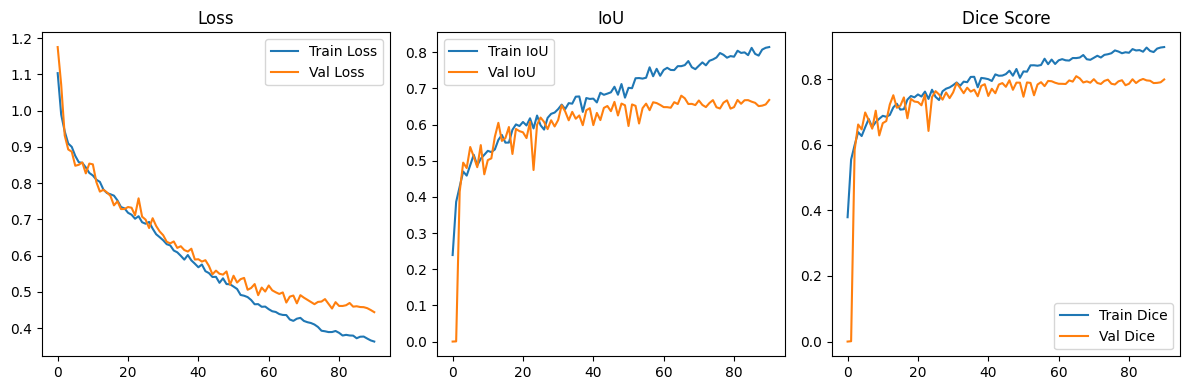

AttributeError: 'Namespace' object has no attribute 'size'

In [11]:
utils.plot_curves(config.model)
show_predictions(count=10, X_val=X_val, y_val=y_val, model=model, size=config.SIZE)